# Multiclass audio segmentation using `auditok` and GMMs

## What is audio segmentation?

Audio segmentation means at least two things:

 - Figure out, within an audio stream (audio file, network stream, audio device, etc.), regions that represent an **audio activity** (no matter what kind of activity) and those that represent **silence**. This type of segmentation is rather referred to as **Audio (or Acoustic) Activity Detection** (**AAD**) and is a binary classification problem.
 - Tell apart, within an audio stream, the nature of **audio activities** (e.g. speech, engine, bird, glass break, etc.). This is a multi-class classification problem.

The former is a much simpler problem. In fact, if what we are looking for is to detect the presence of audio activities (of any kind), we can reply on simple parameters such as signal energy. [**`auditok`**](https://github.com/amsehili/auditok), a tool and API I published recently, can perfectly deal with this problem.

As for recognizing the nature of audio activities within an audio stream, this is a much more complex problem. Two kinds of schemes are used to deal with it: **Segmentation and Classification**  or **Segmentation by Classification**.

### Segmentation and Classification

In this strategy, we would first run an **AAD** to distinguish between silence and noise. Afterwards, we try to classify a detected audio activity to figure out its **sound class**. The problem with this scheme is that if two or more activities are very close in time, they might be **detected** an considered as one single activity, to which the audio classifier will give one single class.

### Segmentation by Classification

In this strategy, we would scan the audio stream to find out when each kind of sound starts and when it ends. This includes the distinction between activities that would have been considered as one single activity by a **Segmentation and Classification** strategy.


The goal of this tutorial is to address the problem of **Segmentation by Classification** of audio streams using [**`auditok`**](https://github.com/amsehili/auditok) as the base tokenizer but with a more advanced classification algorithm. **`auditok`** implements an algorithm based on a 4-state automaton to extract subsequences of data that fulfill a certain number of criteria. It offers flexibility regarding the min./max. length of sequence to extract, max. continuous number of tolerated **non valid** (e.g. silent frames) symbols within a subsequence, etc.

**`auditok`** is basically used an **AAD** tool and uses a **`validator`** based on the signal's **log energy**. It can however easily be used with other kinds of data and validator(s). You can check the documentation for illustrative **`auditok`** [API examples with strings](http://auditok.readthedocs.org/en/latest/apitutorial.html#illustrative-examples-with-strings)


## Sound classes and data

We will consider 5 classes for this **Segmentation by Classification** problem:

- **Speech**
- **Breath**
- **Whistle**
- **Sewing machine**
- **Wrapping paper** (noise of)

We will use manually cropped and annotated data to create a **Gaussian Mixture Model** (**GMM**) for each of these classes. We also create a **GMM** model for silence.

The data are recorded using the same hardware. For **speech** we use a pronunciation of English numbers from 1 to 5 to train the model.

For test, we use an about 50-second long audio file in which each of these classes happens at least twice at arbitrary times. Of course, there is absolutely no overlap between this file and any of training files. For speech, utterances in languages other than English are used (French and German).

## Method

Usually, to be classified, a sound is split into a sequence of very short overlapping frames from which we extract **spectral** and/or **cepstral** coefficients (although other kinds of coefficients, extracted from raw signal, such as **Zero Crossing Rate** can also be used). In this tutorial we are going to use **MFCC** coefficients (**Mel-Frequency Cepstral Coefficients**) and their first and second derivatives.

I have been working on sound classification problems for about 6 years (environmental sounds, emotion in voice, speaker identification etc.). The least I can say is that when using a **frame-level** scheme, an aggregation strategy should be used. With **GMM** classifiers for instance, we would sum up the **log likelihood** of feature vectors the sound is made up of. The unknown sound is given the label of the **GMM** model that yields the highest sum of **log likelihoods**. Along with **frame-level** techniques, there are also **segment-level** techniques. **SVM super vector**-based approaches for instance transform a sequence of feature vectors into one huge vector (e.g. a super vector made up of stacked mean vectors of an adapted **GMM Universal Background Model**) that is classified by an **SVM** classifier.

**`auditok`**'s core tokenization class, [**`StreamTokenizer`**](http://auditok.readthedocs.org/en/latest/core.html), takes a decision only based on the current frame. It calls the **`read()`** method of a [**`DataSource`**](http://auditok.readthedocs.org/en/latest/util.html#auditok.util.DataSource) object (the data of which are to be segmented/tokenized) to read a frame at once and asks its encapsulated **`validator`** if it is a valid frame or not. The [log energy based](http://auditok.readthedocs.org/en/latest/util.html#auditok.util.AudioEnergyValidator) validator that is part of the **`auditok`** package would simply compute the **log energy** of the given frame and return **`True`** if it is >= a user-defined threshold, **`False`** otherwise.


Clearly we don't want the **GMM**-based **`validator`** we are going to implement for this tutorial to simply take a decision based on one single frame (though this would work for certain sound classes as we will see below). The solution to this problem is as follows: we implement a **`DataSource`** class that can not only return the current frame, but also the **context** of the frame with the desired scope. The **context** here stands for the *k* frames that are just before (i.e. history) and after (i.e. future) the current frame. Thus, each **`DataSource.read()`** can optionally (if scope > 0) return a sequence of vectors that the a **GMM**-based validator will score.

Later on, we will try different scope values, but first let us explain the code piece by piece. Don't forget to run the code in each cell so it is taken into account in the following ones.

## Code

### Import required classes and modules

We will first import **GMM** class from **`sklearn.mixture`**, **`librosa`** for audio features extraction and some classes from **`auditok`**:

In [2]:
import wave
import pickle
import numpy as np
from sklearn.mixture import GMM
import librosa
from auditok import DataValidator, ADSFactory, DataSource, StreamTokenizer, BufferAudioSource, player_for

### Define functions to compute MFCC features from librosa
We define functions that extract **MFCC** features from an audio signal or a file with optionally their **delat-1** and **delta-2** coefficients:

In [3]:
def extract_mfcc(signal, sr=16000, n_mfcc=16, n_fft=256, hop_length=128, n_mels = 40, delta_1 = False, delta_2 = False):
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    if not (delta_1 or delta_2):
        return mfcc.T
    
    feat = [mfcc]
    
    if delta_1:
        mfcc_delta_1 = librosa.feature.delta(mfcc, order=1)
        feat.append(mfcc_delta_1)
    
    if delta_2:
        mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)
        feat.append(mfcc_delta_2)
        
    return np.vstack(feat).T


def file_to_mfcc(filename, sr=16000, **kwargs):
    
    signal, sr = librosa.load(filename, sr = sr)
    
    return extract_mfcc(signal, sr, **kwargs)

### Define a class for multi-class classification using GMMs
We define our multi-class classifier that uses [**sklearn's GMM**](http://scikit-learn.org/stable/modules/mixture.html#mixture) objects:

In [4]:
class GMMClassifier():
    
    def __init__(self, models):
        """
        models is a dictionary: {"class_of_sound" : GMM_model_for_that_class, ...}
        """        
        self.models = models
    
    def predict(self, data):
        
        result = []
        for cls in self.models:
            
            llk = self.models[cls].score_samples(data)[0]
            llk = np.sum(llk)
            result.append((cls, llk)) 
        
        """
        return classification result as a sorted list of tuples ("class_of_sound", log_likelihood)
        best class is the first element in the list
        """
        return sorted(result, key=lambda f: - f[1])

Default **`auditok`** frame **`validator`** class is [**AudioEnergyValidator**](http://auditok.readthedocs.org/en/latest/util.html#auditok.util.AudioEnergyValidator) which only computes the log energy of a given slice of signal (here referred to as frame or analysis window), returns **`True`** if the result equals or is above a certain threshold, and **`False`** otherwise.

Thus, [**`AudioEnergyValidator`**](http://auditok.readthedocs.org/en/latest/util.html#auditok.util.AudioEnergyValidator) is not capable of distinguishing between different classes of sounds such as speech, cough or a noise of an electric engine. To build a **`validator`** that can track a particular class of sound (e.g. speech or whistle) over an audio stream, we build a validator that uses a more sophisticated tool to decide whether a frame is valid (belongs to the class of interest) or not.

### A validator that relies on a GMM classifier
The following validator encapsulates an instance of the **`GMMClassifier`** defined above, and checks, for each frame, if the best **label** the **`GMMClassifier`** returns is the same as its **`target`** (i.e. class of interest).

In [5]:
class ClassifierValidator(DataValidator):
    
    def __init__(self, classifier, target):
        """
        classifier: a GMMClassifier object
        target: string
        """
        self.classifier = classifier
        self.target = target
        
    def is_valid(self, data):
        
        r = self.classifier.predict(data)
        return r[0][0] == self.target

### A `DataSource` class that returns feature vectors

Although **`auditok`** is meant for audio segmentation, its core class, **`StreamTokenizer`**, does not expect a a particular type of data (see [API Tutorial](http://auditok.readthedocs.org/en/latest/apitutorial.html) for examples that use **`strings`** instead of audio data). It just expects an object that has a **`read()`** method with no arguments.

In the following, we will implement a class that encapsulates an audio stream as sequence of precomputed audio feature vectors (e.g. **MFCC**) and return one vector each time its **`read()`** method is called.

Furthermore, we want our class to be able to return a vector and its **context** for a **`read()`** call. By context we mean *k* previous and *k* next vectors. This is a valuable feature, because, as we well see, for our audio classification problem, **GMMs** work better if object to classify contains multiple observations (i.e. vectors) and not only one single vector.


In [6]:
class VectorDataSource(DataSource):
     
    def __init__(self, data, scope=0):
        self.scope = scope
        self._data = data
        self._current = 0
    
    def read(self):
        if self._current >= len(self._data):
            return None
        
        start = self._current - self.scope
        if start < 0:
            start = 0
            
        end = self._current + self.scope + 1
        
        self._current += 1
        return self._data[start : end]
    
    def set_scope(self, scope):
        self.scope = scope
            
    def rewind(self):
        self._current = 0

### Initialize some global variables

In the following we are going to define some global variables: 

In [7]:
"""
Size of audio window for which MFCC coefficients are calculated
"""
ANALYSIS_WINDOW = 0.02 # 0.02 second = 20 ms

"""
Step of ANALYSIS_WINDOW 
"""
ANALYSIS_STEP = 0.01 # 0.01 second overlap between consecutive windows

"""
number of vectors around the current vector to return.
This will cause VectorDataSource.read() method to return
a sequence of (SCOPE_LENGTH * 2 + 1) vectors (if enough
data is available), with the current vetor in the middle
"""
SCOPE_LENGTH = 10

"""
Number of Mel filters
"""
MEL_FILTERS = 40

"""
Number of MFCC coefficients to keep
"""
N_MFCC = 16

"""
Sampling rate of audio data
"""
SAMPLING_RATE = 16000

"""
ANALYSIS_WINDOW and ANALYSIS_STEP as number of samples
"""
BLOCK_SIZE = int(SAMPLING_RATE * ANALYSIS_WINDOW)
HOP_SIZE = int(SAMPLING_RATE * ANALYSIS_STEP)

"""
Compute delta and delta-delta of MFCC coefficients ?
"""
DELTA_1 = True
DELTA_2 = True

"""
Where to find data
"""
PREFIX = "data/train"

### Train GMM models and initialize validators

In the following cell we create our **GMM** models (one per class of sound) using training audio files. We then create a **validator** object for each audio class:

In [8]:
train_data = {}

train_data["silence"] = ["silence_1.wav", "silence_2.wav", "silence_3.wav"]
train_data["speech"]  = ["speech_1.wav", "speech_2.wav", "speech_3.wav", "speech_4.wav", "speech_5.wav"]
train_data["breath"]  = ["breath_1.wav", "breath_2.wav", "breath_3.wav", "breath_4.wav", "breath_5.wav"]
train_data["whistle"] = ["whistle_1.wav", "whistle_2.wav", "whistle_3.wav", "whistle_4.wav", "whistle_5.wav"]
train_data["wrapping_paper"] = ["wrapping_paper.wav"]
train_data["sewing_machine"] = ["sewing_machine.wav"]

models = {}

# build models
for cls in train_data:

    data = []
    for fname in train_data[cls]:
        data.append(file_to_mfcc(PREFIX + '/' + fname, sr=16000, n_mfcc=N_MFCC, n_fft=BLOCK_SIZE, hop_length=HOP_SIZE, n_mels=MEL_FILTERS, delta_1=DELTA_1, delta_2=DELTA_2))

    data = np.vstack(data)
    
    print("Class '{0}': {1} training vectors".format(cls, data.shape[0]))

    mod = GMM(n_components=10)
    mod.fit(data)
    models[cls] = mod

gmm_classifier = GMMClassifier(models)

# create a validator for each sound class
silence_validator = ClassifierValidator(gmm_classifier, "silence")
speech_validator = ClassifierValidator(gmm_classifier, "speech")
breath_validator = ClassifierValidator(gmm_classifier, "breath")
whistle_validator = ClassifierValidator(gmm_classifier, "whistle")
sewing_machine_validator = ClassifierValidator(gmm_classifier, "sewing_machine")
wrapping_paper_validator = ClassifierValidator(gmm_classifier, "wrapping_paper")


Class 'wrapping_paper': 1160 training vectors
Class 'sewing_machine': 418 training vectors
Class 'breath': 696 training vectors
Class 'whistle': 399 training vectors
Class 'speech': 263 training vectors
Class 'silence': 4254 training vectors


### Or load pre-trained GMM models

Unfortunately, **sklrean**'s **GMM** implementation is not deterministic. If you'd prefer to use exactly the same models as mine, run the following cell: 

In [9]:
models = {}

for cls in ["silence" , "speech", "breath", "whistle", "sewing_machine", "wrapping_paper"]:
    fp = open("models/%s.gmm" % (cls), "r")
    models[cls] = pickle.load(fp)
    fp.close()

gmm_classifier = GMMClassifier(models)

# create a validator for each sound class
silence_validator = ClassifierValidator(gmm_classifier, "silence")
speech_validator = ClassifierValidator(gmm_classifier, "speech")
breath_validator = ClassifierValidator(gmm_classifier, "breath")
whistle_validator = ClassifierValidator(gmm_classifier, "whistle")
sewing_machine_validator = ClassifierValidator(gmm_classifier, "sewing_machine")
wrapping_paper_validator = ClassifierValidator(gmm_classifier, "wrapping_paper")

### If you wan to save your models to disk, run the following code

In [ ]:
# if you wan to save models
for cls in train_data:
    fp = open("models/%s.gmm" % (cls), "wb")
    pickle.dump(models[cls], fp, pickle.HIGHEST_PROTOCOL)
    fp.close()


### Transform stream to be analyzed into a sequence of vectors
We need to transform the audio stream we want to analyze into a sequence of **MFCC** vectors. We then use the sequence of **MFCC** vectors to create a **VectorDataSource** object that will make it possible to read a vector and its surrounding context if required:

In [10]:
# transform audio stream to be analyzed into a sequence of MFCC vectors
# create a DataSource object using MFCC vectors
mfcc_data_source = VectorDataSource(data=file_to_mfcc("data/analysis_stream.wav",
                                                      sr=16000, n_mfcc=N_MFCC,
                                                      n_fft=BLOCK_SIZE, hop_length=HOP_SIZE,
                                                      n_mels=MEL_FILTERS, delta_1=DELTA_1,
                                                      delta_2=DELTA_2), scope=SCOPE_LENGTH)

### Initialize the tokenizer object
We will use the same tokenizer object all over our tests. We however need to set a different validator to track a particular sound class (examples below).

In [11]:
# create a tokenizer
analysis_window_per_second = 1. / ANALYSIS_STEP

min_seg_length = 0.5 # second, min length of an accepted audio segment
max_seg_length = 10 # seconds, max length of an accepted audio segment
max_silence = 0.3 # second, max length tolerated of tolerated continuous signal that's not from the same class

tokenizer = StreamTokenizer(validator=speech_validator, min_length=int(min_seg_length * analysis_window_per_second),
                                max_length=int(max_seg_length * analysis_window_per_second),
                                max_continuous_silence= max_silence * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)

### Read audio signal used for visualization purposes

In [12]:
# read all audio data from stream
wfp = wave.open("data/analysis_stream.wav")
audio_data = wfp.readframes(-1)
width = wfp.getsampwidth()
wfp.close()

# data as numpy array will be used to plot signal
fmt = {1: np.int8 , 2: np.int16, 4: np.int32}
signal = np.array(np.frombuffer(audio_data, dtype=fmt[width]), dtype=np.float64)

### Define plot function

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 24, 18

def plot_signal_and_segmentation(signal, sampling_rate, segments=[]):
    _time = np.arange(0., np.ceil(float(len(signal))) / sampling_rate, 1./sampling_rate )
    if len(_time) > len(signal):
        _time = _time[: len(signal) - len(_time)]
    
    pylab.subplot(211)

    for seg in segments:
        
        fc = seg.get("fc", "g")
        ec = seg.get("ec", "b")
        lw = seg.get("lw", 2)
        alpha = seg.get("alpha", 0.4)
        
        ts = seg["timestamps"]
        
        # plot first segmentation outside loop to show one single legend for this class
        p = pylab.axvspan(ts[0][0], ts[0][1], fc=fc, ec=ec, lw=lw, alpha=alpha, label = seg.get("title", ""))
        
        for start, end in ts[1:]:
            p = pylab.axvspan(start, end, fc=fc, ec=ec, lw=lw, alpha=alpha)
            
            
    pylab.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
            borderaxespad=0., fontsize=22, ncol=2)
    
    pylab.plot(_time, signal)
    
    pylab.xlabel("Time (s)", fontsize=22)
    pylab.ylabel("Signal Amplitude", fontsize=22)
    pylab.show()


### Read and plot manual annotations (used for visualization an comparison purposes)

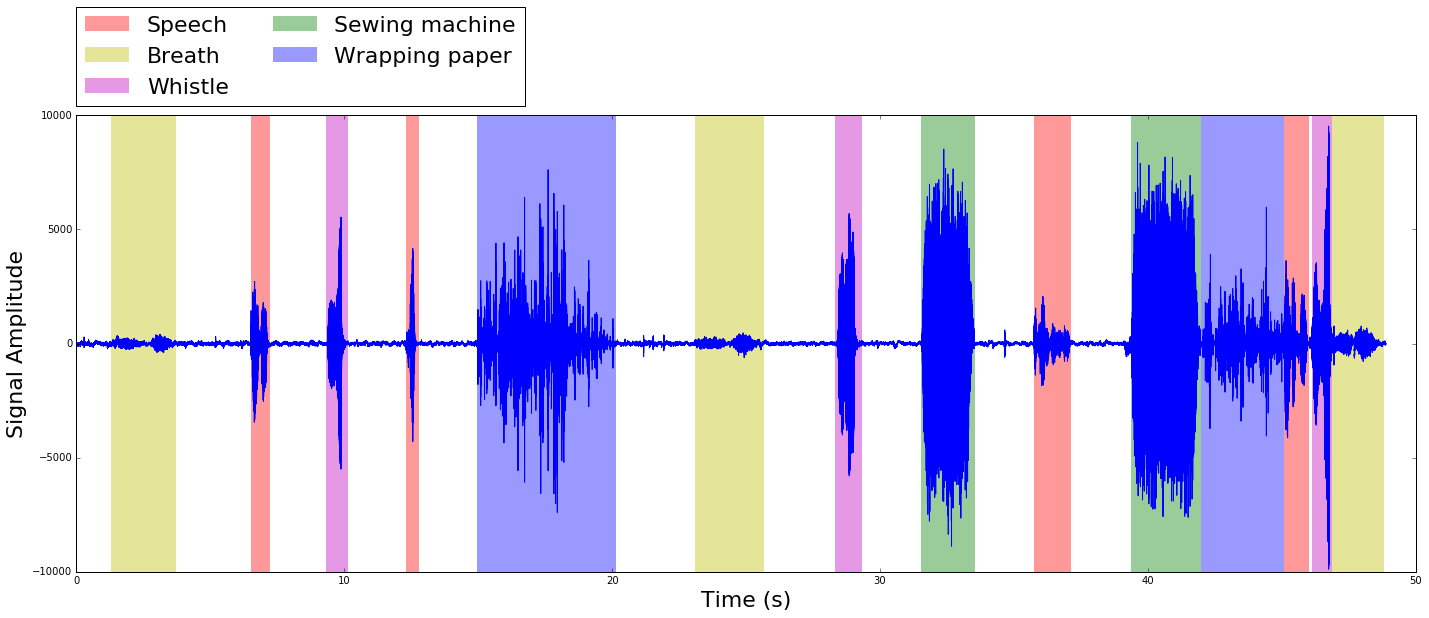

In [14]:
annotations = {}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/speech.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["speech"] = {"fc" : "r", "ec" : "r", "lw" : 0, "alpha" : 0.4, "title" : "Speech", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/breath.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["breath"] = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/whistle.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["whistle"] = {"fc" : "m", "ec" : "m", "lw" : 0, "alpha" : 0.4, "title" : "Whistle", "timestamps" : ts}


ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/sewing_machine.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["sewing_machine"] = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.4, "title" : "Sewing machine", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("data/wrapping_paper.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["wrapping_paper"] = {"fc" : "b", "ec" : "b", "lw" : 0, "alpha" : 0.4, "title" : "Wrapping paper", "timestamps" : ts}

def plot_annot():
    plot_signal_and_segmentation(signal, SAMPLING_RATE,
                             [annotations["speech"],
                              annotations["breath"],
                              annotations["whistle"],
                              annotations["sewing_machine"],
                              annotations["wrapping_paper"]
                             ])

plot_annot()

## Try out the the first segmentation with sewing_machine class
Now, let us start off with a somehow *easy* class. The **sewing_machine** is a good candidate. This sound has strong components in low frequencies and less strong high frequencies that both remain very stable over time. It is easy to distinguish from our other classes, even with absolute frame-level validation (i.e. no context, `scope = 0`)

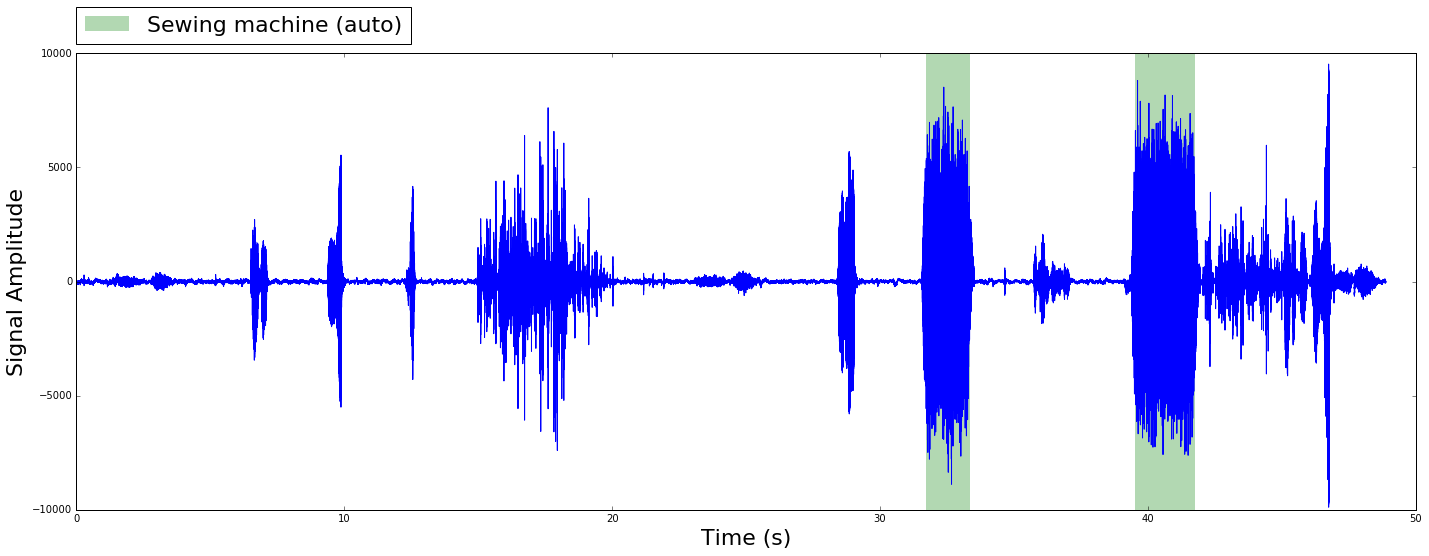

In [15]:
tokenizer = StreamTokenizer(validator=speech_validator, min_length= int(0.5 * analysis_window_per_second),
                                max_length=int(15 * analysis_window_per_second),
                                max_continuous_silence= 0.3 * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)
tokenizer.validator = sewing_machine_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]

seg = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.3, "title" : "Sewing machine (auto)", "timestamps" : ts}

plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

doesn't, please re-run the training to obtain (hopefully) better models or use the models the worked for me by running the respective cell.

Note that, we used a scope size of zero. That means that only one single vector is returned by the **read()** and evaluated by **is_valid()** methods. This absolute frame-level classification scheme will not have as much success for less stationary classes such speech. Let us try the same strategy with class **breath**.

## Track breath with an absolute frame-level scheme

We will keep the same tokenizer but set its **validator** object to **breath_validator** so that it tracks breath over the stream:

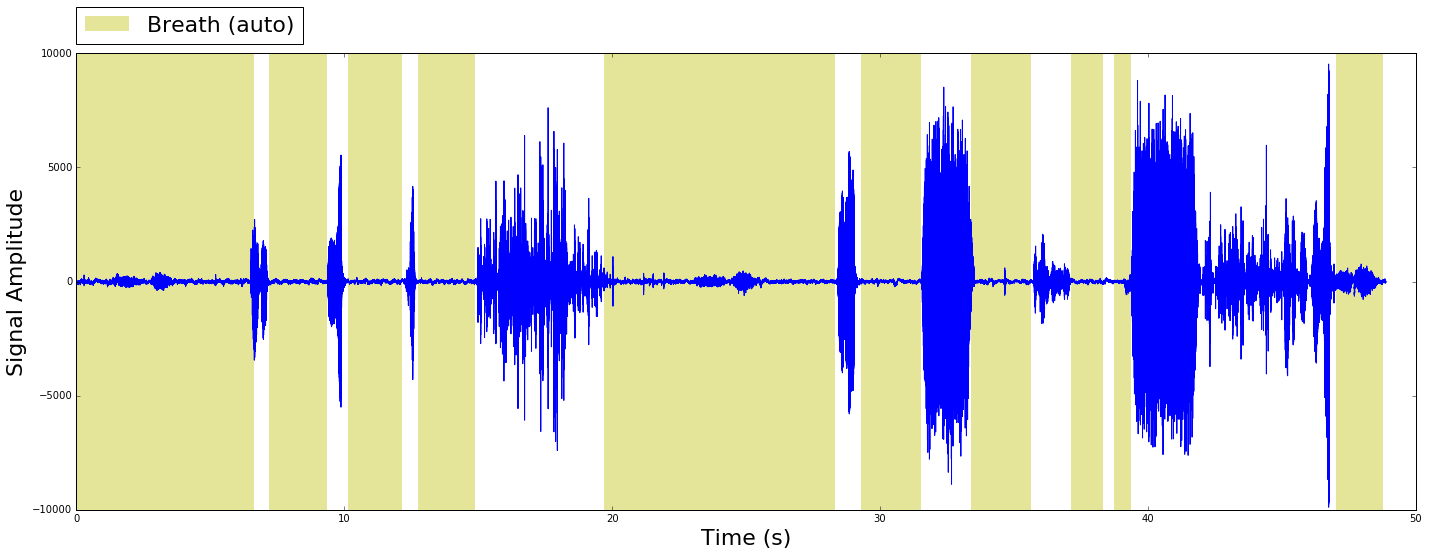

In [16]:
tokenizer.validator = breath_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath (auto)", "timestamps" : ts}
plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

As you can see, this results in a considerable number of false alarms, almost all silence is classified as breath (remember that you can plot annotations using **plot_annot()**).

The good news is that only **silence** and no other class is wrongly classified as **breath**. Hence, there are good chances that using another audio feature such energy would help.


## Track breath with a larger scope

Let us now use a wider scope, so that a vector is evaluated within its context. We will set the scope of our **mfcc_data_source** to 25. Note that by reading 25 vectors before and after the current vector, we are analyzing audio chunks of 51 * 10 = 510 ms (analysis step is 10 ms).

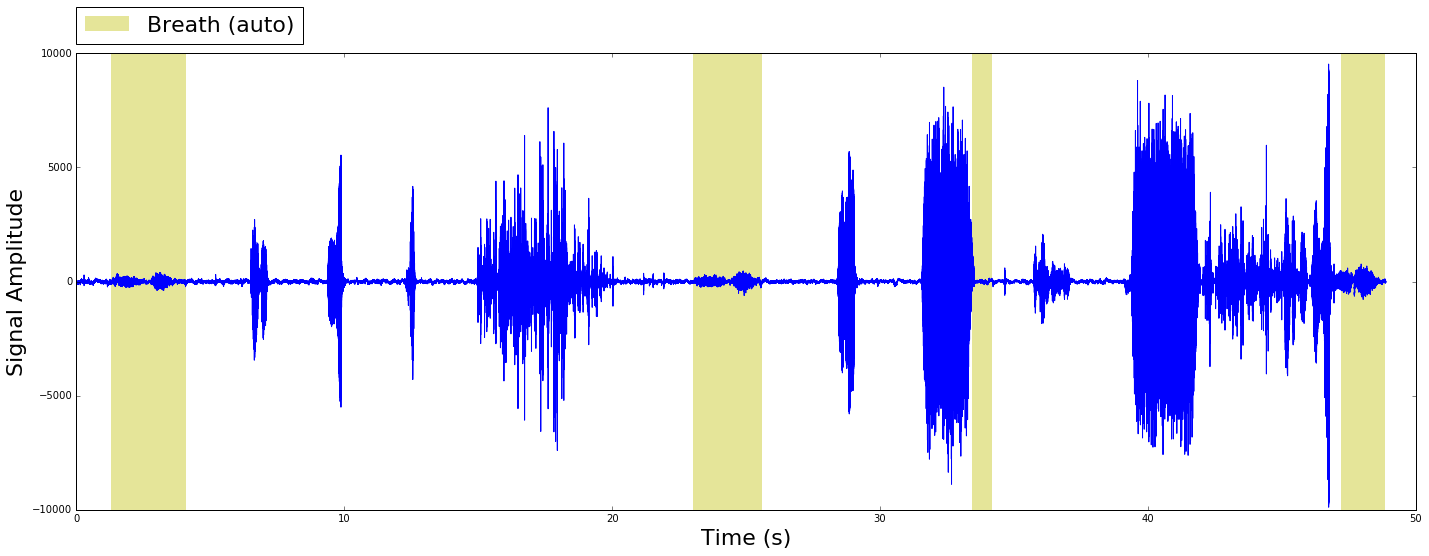

In [17]:
mfcc_data_source.rewind()
mfcc_data_source.scope = 25
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath (auto)", "timestamps" : ts}
plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

Using a wider scope yields a much better segmentation for class **breath** (again, if you are not having the same result, please load models that worked for me, trained using the SAME training data). The number of false alarms is greatly reduced.

Scope size should however be chosen with precaution. Using very large scopes may lead to poorer temporal precision or increase false alarms.

## Track all classes, this is multi-class segmentation!
Now we are going to automatically track all our classes (except **silence**) within the stream. You might have noticed that the end of the streams contains the most challenging part. It contains 5 juxtaposed sections representing our 5 classes with almost no silence between them. If we intend to use a **Segmentation and Classification** scheme, an energy-based detector would definitely fail to isolate the five events.

Let us see if we can do better with a **Segmentation by Classification** scheme. As you know, **StreamTokenizer** objects are binary classifiers. For our multi-class classification problem, we will use as much **StreamTokenizer** objects as there are sound classes.

We will therefore run a **tokenizer** for each class and then plot the whole obtained results. Although one can use some workaround to speed up processing (e.g. use a **`DataSource`** of precomputed log likelihoods instead of **MFCC** vectors, etc.), this is not the goal of this tutorial. The following code will plot the automatic segmentation followed by the manual annotation.

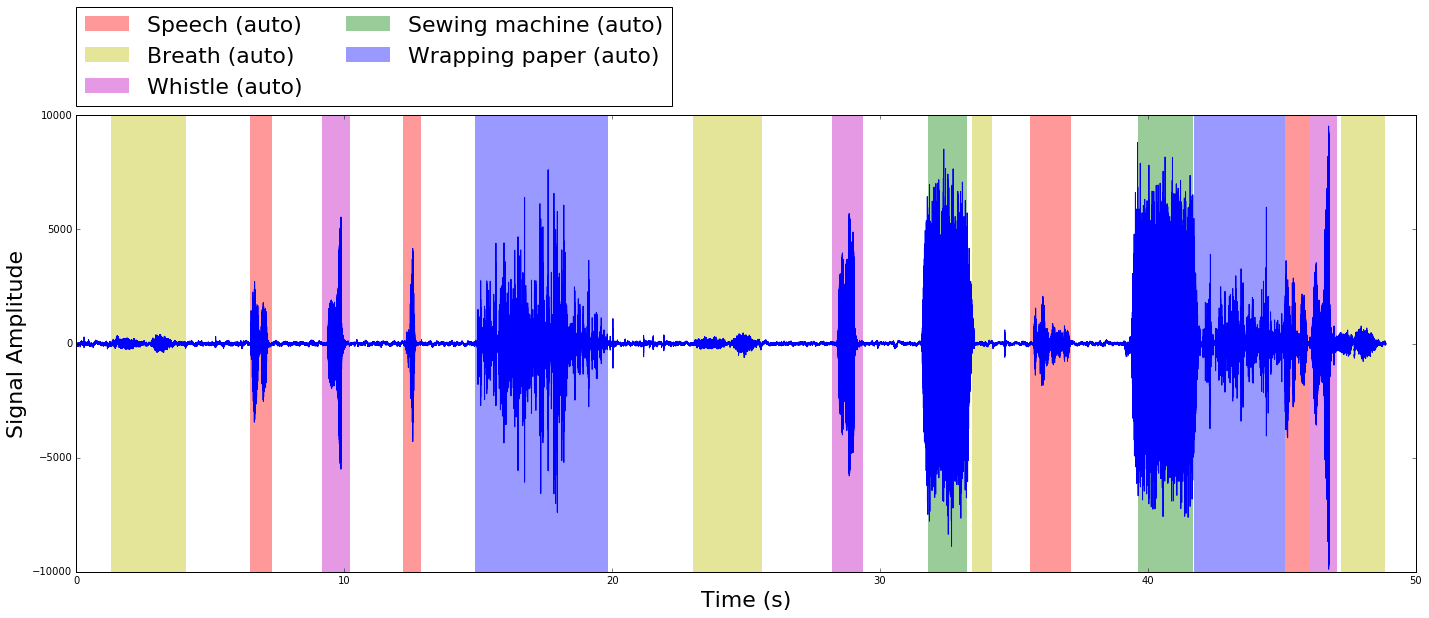

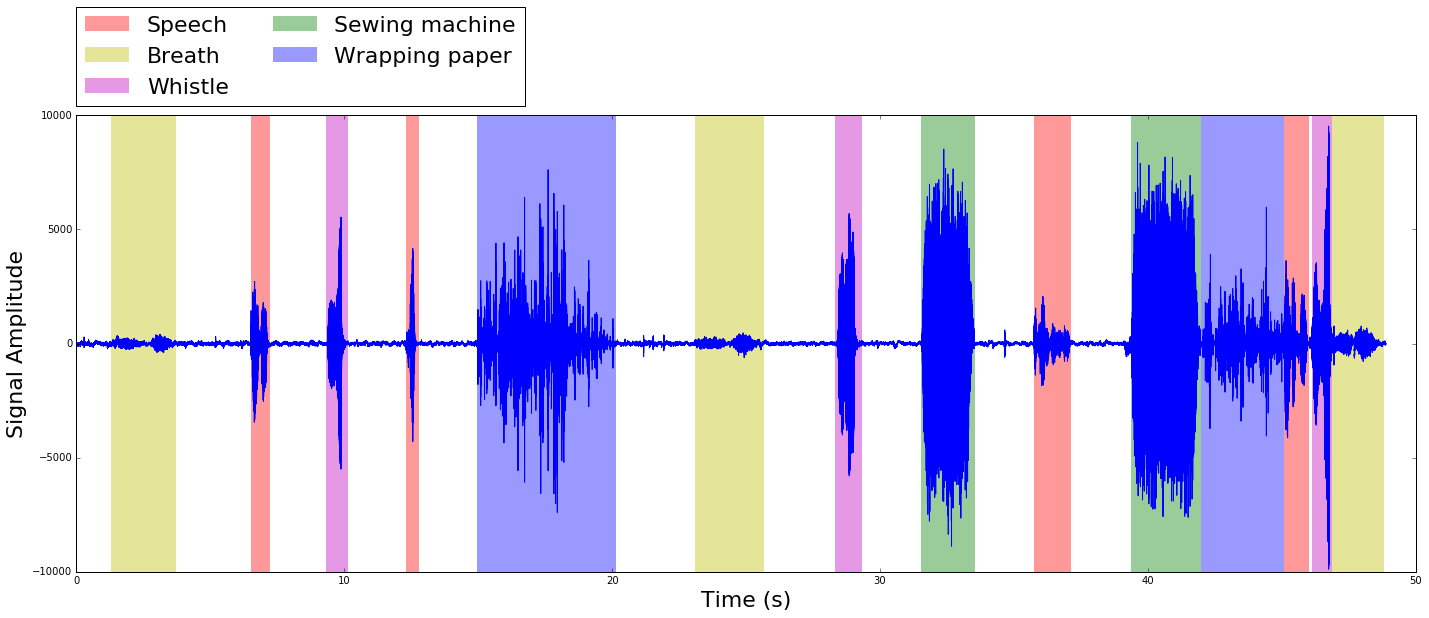

In [18]:
segments = []
mfcc_data_source.scope = 25

# track speech
mfcc_data_source.rewind()
tokenizer.validator = speech_validator
tokens = tokenizer.tokenize(mfcc_data_source)
speech_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "r", "ec" : "r", "lw" : 0, "alpha" : 0.4, "title" : "Speech (auto)", "timestamps" : speech_ts}
segments.append(seg)


# track breath
mfcc_data_source.rewind()
tokenizer.validator = breath_validator
tokens = tokenizer.tokenize(mfcc_data_source)
breath_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath (auto)", "timestamps" : breath_ts}
segments.append(seg)

# track whistle
mfcc_data_source.rewind()
tokenizer.validator = whistle_validator
tokens = tokenizer.tokenize(mfcc_data_source)
whistle_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "m", "ec" : "m", "lw" : 0, "alpha" : 0.4, "title" : "Whistle (auto)", "timestamps" : whistle_ts}
segments.append(seg)

# track sewing_machine
mfcc_data_source.rewind()
tokenizer.validator = sewing_machine_validator
tokens = tokenizer.tokenize(mfcc_data_source)
sewing_machine_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.4, "title" : "Sewing machine (auto)", "timestamps" : sewing_machine_ts}
segments.append(seg)

# track wrapping_paper
mfcc_data_source.rewind()
tokenizer.validator = wrapping_paper_validator
tokens = tokenizer.tokenize(mfcc_data_source)
wrapping_paper_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "b", "ec" : "b", "lw" : 0, "alpha" : 0.4, "title" : "Wrapping paper (auto)", "timestamps" : wrapping_paper_ts}
segments.append(seg)

# plot automatic segmentation
plot_signal_and_segmentation(signal, SAMPLING_RATE, segments)

# plot manual segmentation
plot_annot()

If it wasn't for **breath** false alarm, we'd have a perfect automatic output...

### If you want to play some audio segments, prepare this...

In [ ]:
# BufferAudioSource is useful if we want to navigate quickly within audio data and play
bas = BufferAudioSource(audio_data, SAMPLING_RATE, width, 1)
bas.open()

# audio playback requires pyaudio
player = player_for(bas)

### Play first instance of wrapping_paper class

In [ ]:
start , end = wrapping_paper_ts[0]
bas.set_time_position(start)
data = bas.read(int((end-start) * bas.get_sampling_rate()))
player.play(data)

## Conclusion

This tutorial addresses the problem of audio **Segmentation by Classification**. The presented technique uses **GMM** as classification method and leverages `auditok` sequence extraction algorithm to track a particular kind of sound over an audio stream. The user is encouraged to experience other classification methods.

If you're interested in sound recognition and audio indexation problematics, I'll be happy to share my experience with you!

## Repository

[On Github](https://github.com/amsehili/audio-segmentation-by-classification-tutorial)

## Author
Amine SEHILI <amine.sehili@gmail.com>